# 2023年 世界モデル 第3回演習

本演習では**Variational autoencoder (VAE)** [[1]](#scrollTo=XMIV_3TOiAq8) [[2]](#scrollTo=XMIV_3TOiAq8) を実装し，MNIST画像の再構成と生成，潜在空間の可視化などを行います．

## 目次

1. [MNISTデータセットの読み込み](#scrollTo=kh_PpFMVKXFA)
2. [Variational autoencoder (VAE)の実装](#scrollTo=lDwFTAWbKXE-)
  - 2.1. [VAEの復習](#scrollTo=5BNRLQm9KXFJ)
  - 2.2. [VAEの実装](#scrollTo=oWwOTcCzRNXb)
  - 2.3. [学習](#scrollTo=oYo_zWwBjrJ4)
3. [再構成画像の可視化](#scrollTo=PbS4E_GHKXFl)
  - 3.1. [Original image](#scrollTo=ZpVnPZjXKXFy)
  - 3.2. [Reconstruction image](#scrollTo=nVHNlRWAKXF6)
4. [潜在変数からランダムサンプリング](#scrollTo=WIUlxxxEKXF-)
5. [潜在空間のプロット](#scrollTo=sP6C1RqaSHDi)
6. [潜在空間の多様体の可視化](#scrollTo=yWyBK_14KXGW)
7. [[参考] Vector Quantized VAE (VQ-VAE)](#scrollTo=ZRMWJU76LS3B)
8. [参考文献](#scrollTo=XMIV_3TOiAq8)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd
import torch.nn.functional as F
from torchvision import datasets, transforms, models

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from typing import Tuple

rng = np.random.RandomState(1234)
random_state = 42

## 1.MNISTデータセットの読み込み

In [4]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.view(-1))
    ]
)

batch_size = 128
device = 'mps'
n_epochs = 15

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=True, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True
)

valid_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform),
    batch_size=batch_size,
    shuffle=False
)

100%|██████████| 9912422/9912422 [00:06<00:00, 1623372.38it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 2499189.06it/s]


Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 4013253.58it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 985440.14it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



## 2.Variational autoencoder (VAE) の実装

### 2.1. VAEの復習

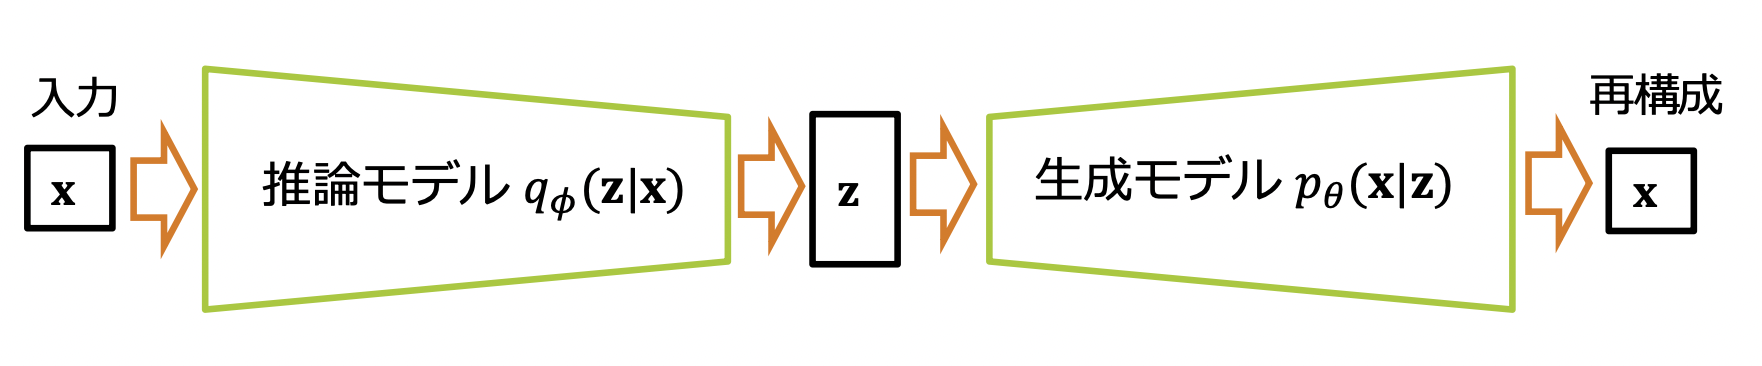

**VAEのエンコーダとデコーダは，それぞれ次のように表されます．**
- エンコーダ（例：ガウス分布）：$$q_{\phi}({\bf z}|{\bf x}) = {\mathcal N}({\bf z}| \mu,\sigma^2{\bf I}), 　ただし\mu=g^{\mu}_{\phi}({\bf x}), \sigma=g^{\sigma}_{\phi}({\bf x}). $$
- デコーダ（例：ベルヌーイ分布）：$$p_{\theta}({\bf x}|{\bf z}) = Bern({\bf x}| \lambda), 　ただし\lambda=f_{\theta}({\bf z}).$$
<br>

**また，VAEの下界（目的関数）は次のとおりです．**第1項が講義内の（負の）再構成誤差，第2項が正則化項に対応しています．


$$
 {\mathcal L}({\bf x};{\bf \theta},{\bf \phi}) = \mathbb{E}_{q_{\phi}({\bf z}|{\bf x})}[\log p_\theta({\bf x}|{\bf z})] -D_{KL}[q_{\phi}({\bf z}|{\bf x})||p({\bf z})]
 $$  

目的関数の第1項は，次のようにサンプル近似できます．
$$
  \mathbb{E}_{q_{\phi}({\bf z}|{\bf x})}[\log p_\theta({\bf x}|{\bf z})]\simeq \frac{1}{L}\sum_{l=1}^L\log p_\theta({\bf x}|{\bf z}^{(l)}),  　ただし{\bf z}^{(l)} = \mu + \sigma \odot \epsilon^{(l)}, \epsilon^{(l)}\sim N(0,{\bf I})
$$

なお，デコーダは[ベルヌーイ分布](https://ja.wikipedia.org/wiki/%E3%83%99%E3%83%AB%E3%83%8C%E3%83%BC%E3%82%A4%E5%88%86%E5%B8%83)なので，上式右辺は次のように計算できます．

$$
  \frac{1}{L}\sum_{l=1}^L\log p_\theta({\bf x}|{\bf z}^{(l)})=\frac{1}{L}\sum_{l=1}^L \sum_{i=1}^D (x_i \log \lambda^{(l)}_i + (1-x_i)\log (1-\lambda^{(l)}_i)),　ただし\lambda^{(l)}=f_{\theta}({\bf z}^{(l)})
$$


上式は実装内の`reconstruction`に対応しています．今回の演習では$L=1$を採用します．また，Dはサンプルの次元数`784`に対応します．

目的関数の第2項については，次のように解析的に計算できます．（[正規分布同士のKLダイバージェンス](https://leenashekhar.github.io/2019-01-30-KL-Divergence/)）
$$
  D_{KL}[q_{\phi}({\bf z}|{\bf x})||p({\bf z})] = -\frac{1}{2}\sum_{j=1}^J(1+\log(\sigma_j^2)-\mu_j^2-\sigma_j^2), 　ただしp({\bf z})={\cal N}(0,{\bf I})
$$

上式は実装内の`KL`に対応しています．また，Jは潜在変数の次元数`z_dim`に対応します．

### 2.2. VAEの実装

以上を踏まえて，VAEを実装していきます．

- `__init__(self, z_dim)`

> エンコーダ，デコーダそれぞれを [`nn.Linear()`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=nn%20linear#torch.nn.Linear)からなる全結合型のニューラルネットワークとして構築します．
エンコーダではMNIST画像に対応して`self.dense_enc1`に784(28*28)次元の入力を受け取り，次元削減により最終的には`z_dim`の出力特徴を持ちます．デコーダでは逆に次元を増加させます．

- `_encoder(self, x)`

>  入力画像`x`を受け取り，$\mu=g^{\mu}_{\phi}({\bf x}),\sigma=g^{\sigma}_{\phi}({\bf x}) $で定義した`mean, std`を返します．`std`がマイナスの値を取らないように [`F.softplus()`](https://pytorch.org/docs/stable/generated/torch.nn.functional.softplus.html#torch.nn.functional.softplus)を用います．

- `_sample_z(self, mean, var)`

> Backpropagationを可能にするため，再パラメータ化トリック (${\bf z}^{(l)} = \mu + \sigma \odot \epsilon^{(l)}$) を実装します．

- `_decoder(self, z)`

> 潜在変数`z`を受け取り，MNIST画像と同じ784次元になるまで次元を復元させ，`x`を返します．


- `forward(self, x)`

> 入力画像`x`を受け取り，再構成画像と潜在変数にあたる`x, z`を返します．

- `loss(self, x)`

> 目的関数を定義していきます．[上式](#scrollTo=kqrsxQunOryj&line=20&uniqifier=1)の通り実装し，目的関数の各項`KL`, `-reconstruction`を返します．注意点として，上式は最大化したい下界なので，ロスとしては符号が逆転し，これを最小化していくことになります．

# WRITE ME

In [7]:
def torch_log(x: torch.Tensor) -> torch.Tensor:
    """ torch.log(0)によるnanを防ぐ． """
    return torch.log(torch.clamp(x, min=1e-10))

class VAE(nn.Module):
    """ VAEモデルの実装 """
    def __init__(self, z_dim: int) -> None:
        """
        クラスのコンストラクタ．

        Parameters
        ----------
        z_dim : int
            VAEの潜在空間の次元数．
        """
        super().__init__()

        # Encoder, xを入力にガウス分布のパラメータmu, sigmaを出力
        self.dense_enc1 = nn.Linear(28*28, 200)
        self.dense_enc2 = nn.Linear(200, 200)
        self.dense_encmean = nn.Linear(200, z_dim)
        self.dense_encvar = nn.Linear(200, z_dim)

        # Decoder, zを入力にベルヌーイ分布のパラメータlambdaを出力
        self.dense_dec1 = nn.Linear(z_dim, 200)
        self.dense_dec2 = nn.Linear(200, 200)
        self.dense_dec3 = nn.Linear(200, 28*28)

    def _encoder(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        VAEのエンコーダ部分．

        Parameters
        ----------
        x : torch.Tensor ( b, c * h * w )
            Flattenされた入力画像．

        Returns
        ----------
        mean : torch.Tensor ( b, z_dim )
            エンコーダがモデリングするガウス分布の平均
        std : torch.Tensor ( b, z_dim )
            エンコーダがモデリングするガウス分布の標準偏差
        """
        x = F.relu(self.dense_enc1(x))
        x = F.relu(self.dense_enc2(x))
        mean = self.dense_encmean(x)
        std = F.softplus(self.dense_encvar(x))

        return mean, std

    def _sample_z(self, mean: torch.Tensor, std: torch.Tensor) -> torch.Tensor:
        """
        訓練時に再パラメータ化トリックによってガウス分布から潜在変数をサンプリングする．
        推論時はガウス分布の平均を返す．

        Parameters
        ----------
        mean : torch.Tensor ( b, z_dim )
            エンコーダがモデリングするガウス分布の平均
        std : torch.Tensor ( b, z_dim )
            エンコーダがモデリングするガウス分布の標準偏差
        """
        if self.training:
            epsilon = torch.randn(mean.shape).to(device)
            return mean + epsilon * std
        else:
            return mean

    def _decoder(self, z: torch.Tensor) -> torch.Tensor:
        """
        VAEのデコーダ部分．

        Parameters
        ----------
        z : torch.Tensor ( b, z_dim )
            潜在変数．

        Returns
        ----------
        x : torch.Tensor ( b, c * h * w )
            再構成画像．
        """
        x = F.relu(self.dense_dec1(z))
        x = F.relu(self.dense_dec2(x))
        # 出力が0~1になるようにsigmoid
        x = torch.sigmoid(self.dense_dec3(x))

        return x

    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        順伝播．

        Parameters
        ----------
        x : torch.Tensor ( b, c * h * w )
            Flattenされた入力画像．

        Returns
        ----------
        x : torch.Tensor ( b, c * h * w )
            再構成画像．
        z : torch.Tensor ( b, z_dim )
            潜在変数．
        """
        mean, std = self._encoder(x)
        z = self._sample_z(mean, std)
        x = self._decoder(z)
        return x, z

    def loss(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        順伝播しつつ目的関数の計算を行う．

        Parameters
        ----------
        x : torch.Tensor ( b, c * h * w )
            Flattenされた入力画像．

        Returns
        ----------
        KL : torch.Tensor (, )
            正則化項．エンコーダ（ガウス分布）と事前分布（標準ガウス分布）のKLダイバージェンス．
        reconstruction : torch.Tensor (, )
            再構成誤差．
        """
        mean, std = self._encoder(x)

        # KL loss(正則化項)の計算. mean, stdは (batch_size , z_dim)
        # torch.sumは上式のJ(=z_dim)に関するもの. torch.meanはbatch_sizeに関するものなので,
        # 上式には書いてありません.
        KL = -0.5 * torch.mean(torch.sum(1 + torch_log(std**2) - mean**2 - std**2, dim=1))

        z = self._sample_z(mean, std)
        y = self._decoder(z)

        # reconstruction loss(負の再構成誤差)の計算. x, yともに (batch_size , 784)
        # torch.sumは上式のD(=784)に関するもの. torch.meanはbatch_sizeに関するもの.
        # バイナリー・クロスエントロピー
        reconstruction = torch.mean(torch.sum(x * torch_log(y) + (1 - x) * torch_log(1 - y), dim=1))
        # reconstruction = F.binary_cross_entropy(y, x, reduction='mean').sum(dim=1).mean()

        return KL, -reconstruction

### 2.3. 学習

In [8]:
z_dim = 2
assert z_dim >= 2

model = VAE(z_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(n_epochs):
    losses = []
    KL_losses = []
    reconstruction_losses = []

    model.train()
    for x, _ in train_loader:

        x = x.to(device)

        model.zero_grad()

        # KL_loss, reconstruction_lossの各項の計算
        KL_loss, reconstruction_loss = model.loss(x)

        # エビデンス下界の最大化のためマイナス付きの各項の値を最小化するようにパラメータを更新
        loss = KL_loss + reconstruction_loss

        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        KL_losses.append(KL_loss.cpu().detach().numpy())
        reconstruction_losses.append(reconstruction_loss.cpu().detach().numpy())

    losses_val = []
    model.eval()
    for x, t in valid_loader:

        x = x.to(device)

        KL_loss, reconstruction_loss = model.loss(x)

        loss = KL_loss + reconstruction_loss

        losses_val.append(loss.cpu().detach().numpy())

    print('EPOCH: %d    Train Lower Bound: %lf (KL_loss: %lf. reconstruction_loss: %lf)    Valid Lower Bound: %lf' %
          (epoch+1, np.average(losses), np.average(KL_losses), np.average(reconstruction_losses), np.average(losses_val)))

EPOCH: 1    Train Lower Bound: 192.921844 (KL_loss: 3.331018. reconstruction_loss: 189.590820)    Valid Lower Bound: 167.593979
EPOCH: 2    Train Lower Bound: 164.636185 (KL_loss: 4.803077. reconstruction_loss: 159.833084)    Valid Lower Bound: 159.759857
EPOCH: 3    Train Lower Bound: 157.927567 (KL_loss: 5.318504. reconstruction_loss: 152.609070)    Valid Lower Bound: 154.731720
EPOCH: 4    Train Lower Bound: 154.390488 (KL_loss: 5.561717. reconstruction_loss: 148.828796)    Valid Lower Bound: 152.500748
EPOCH: 5    Train Lower Bound: 152.153229 (KL_loss: 5.749955. reconstruction_loss: 146.403275)    Valid Lower Bound: 150.487137
EPOCH: 6    Train Lower Bound: 150.217896 (KL_loss: 5.882396. reconstruction_loss: 144.335510)    Valid Lower Bound: 149.264313
EPOCH: 7    Train Lower Bound: 148.905640 (KL_loss: 6.000101. reconstruction_loss: 142.905518)    Valid Lower Bound: 147.505737
EPOCH: 8    Train Lower Bound: 147.721146 (KL_loss: 6.079138. reconstruction_loss: 141.642029)    Valid 

## 3.再構成画像の可視化

### 3.1. Original image

実サンプルを可視化しておきます．

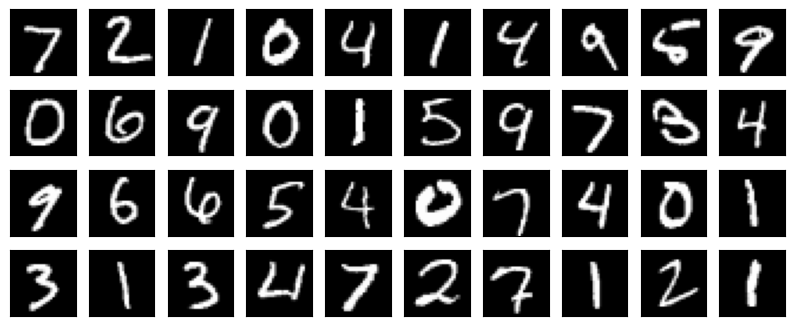

In [9]:
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 4))
model.eval()
for i in range(40):
    x, t = valid_dataset[i]

    im = x.view(-1, 28, 28).permute(1, 2, 0).squeeze().numpy()

    ax = fig.add_subplot(4, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

### 3.2. Reconstruction image

モデルに実サンプルを入れて，再構成された画像を可視化します．

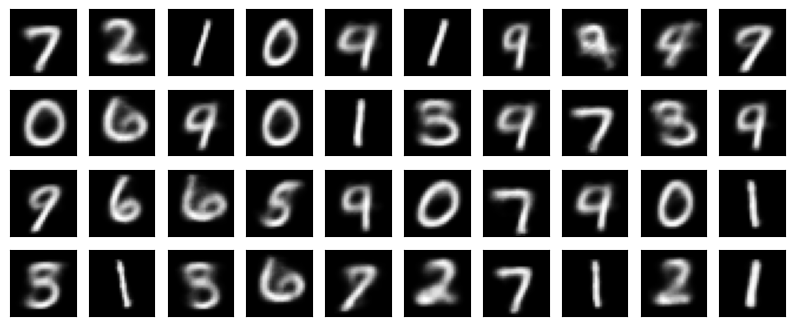

In [10]:
valid_dataset = datasets.MNIST('./data/MNIST', train=False, download=True, transform=transform)
fig = plt.figure(figsize=(10, 4))
model.eval()
for i in range(40):
    x, t = valid_dataset[i]

    x = x.unsqueeze(0).to(device)

    y, z = model(x)

    im = y.view(-1, 28, 28).permute(1, 2, 0).detach().cpu().squeeze().numpy()

    ax = fig.add_subplot(4, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

## 4.潜在変数からのランダムサンプリング

潜在変数をランダムにサンプリングし，それをデコーダに通したものを可視化します．後で可視化する潜在空間の中でどの数字にも該当しない`z`もサンプリングされるので，数字に見えない画像も生成されます．

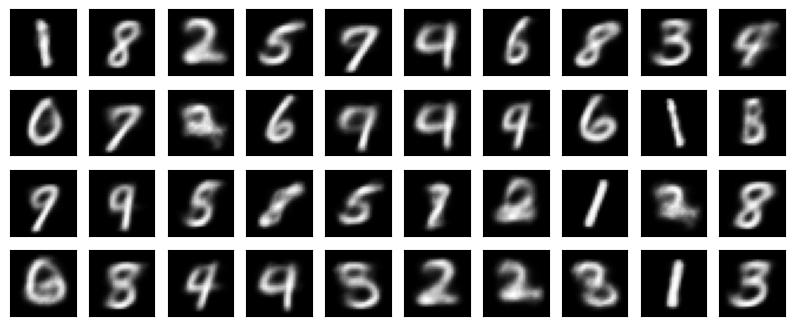

In [11]:
z = torch.randn([40, z_dim]).to(device)

fig = plt.figure(figsize=(10, 4))
model.eval()
for i in range(40):
    y = model._decoder(z[i])

    im = y.view(-1, 28, 28).permute(1, 2, 0).detach().cpu().squeeze().numpy()

    ax = fig.add_subplot(4, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

## 5.潜在空間のプロット

`z_dim=2`にして学習し，潜在変数を可視化してみましょう．（`z_dim>2`の場合は，[t-SNE](https://distill.pub/2016/misread-tsne/)またはPCAで次元削減してプロットします）

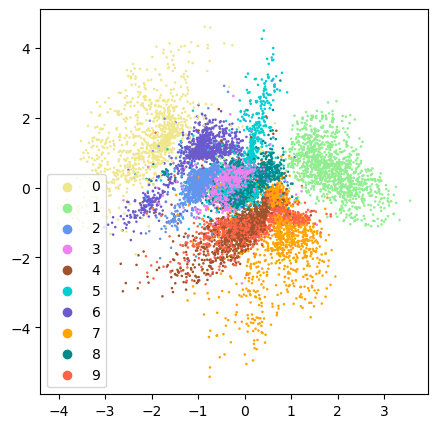

In [12]:
valid_dataset = datasets.MNIST(
    './data/MNIST', train=False, download=True, transform=transform
)

model.eval()

z_list = []
t_list = []
for x, t in valid_dataset:
    t_list.append(t)
    x = x.to(device).unsqueeze(0)
    _, z = model(x)
    z_list.append(z.cpu().detach().numpy()[0])

z_val = np.stack(z_list)

REDUC = 'TSNE' # 'TSNE' または 'PCA'
if z_dim > 2:
    if REDUC == "TSNE":
        z_reduc = TSNE(n_components=2).fit_transform(z_val).T
    elif REDUC == "PCA":
        z_reduc = PCA(n_components=2).fit_transform(z_val).T
    else:
        raise ValueError("Please choose dimensionality reduction method from TSNE or PCA.")
elif z_dim == 2:
    z_reduc = z_val.T
else:
    raise ValueError("z dimensionality must be larger or equal to 2.")

colors = ['khaki', 'lightgreen', 'cornflowerblue', 'violet', 'sienna',
          'darkturquoise', 'slateblue', 'orange', 'darkcyan', 'tomato']

plt.figure(figsize=(5,5))
plt.scatter(*z_reduc, s=0.7, c=[colors[t] for t in t_list])
# 凡例を追加
for i in range(10):
    plt.scatter([],[], c=colors[i], label=i)
plt.legend()

## 6.潜在空間の多様体の可視化

潜在空間内を，あるサンプルから別のサンプルまで遷移し，可視化してみましょう．

start sample label: 7
end sample label: 0


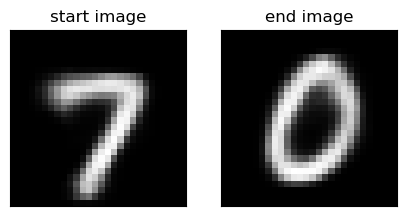

In [13]:
START_SAMPLE_IDX = 0
END_SAMPLE_IDX = 3
TITLES = ["start", "end"]

valid_dataset = datasets.MNIST(
    './data/MNIST', train=False, download=True, transform=transform
)
model.eval()

z_dict = {}
fig = plt.figure(figsize=(5, 5))
for i, sample_idx in enumerate([START_SAMPLE_IDX, END_SAMPLE_IDX]):
    x, t = valid_dataset[sample_idx]
    print(f"{TITLES[i]} sample label: {t}")

    x = x.unsqueeze(0).to(device)
    y, z = model(x)

    image = y.view(-1, 28, 28).permute(1, 2, 0).detach().cpu().squeeze().numpy()
    z_dict.update({TITLES[i]: z})

    ax = fig.add_subplot(1, 2, i+1, xticks=[], yticks=[])
    ax.set_title(f"{TITLES[i]} image")
    ax.imshow(image, 'gray')

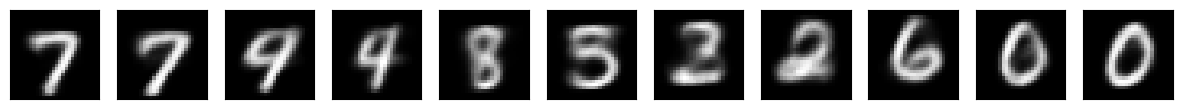

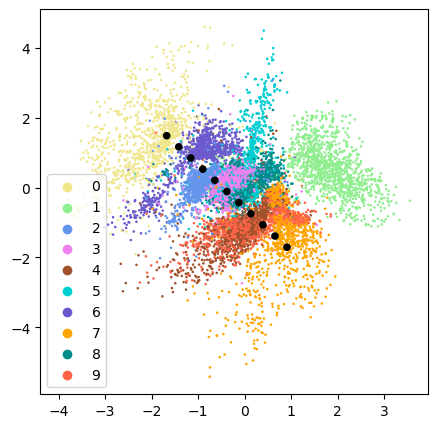

In [19]:
import os
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
device = "mps"

# start sampleのzとend sampleのzの間を線形に補間
# torch.lerpをCPU上で実行
z_interp = torch.cat(
    [torch.lerp(z_dict["start"].cpu(), z_dict["end"].cpu(), weight=w) for w in np.arange(0, 1.1, 0.1)]
).to(device)  # 補間後にMPSデバイスにテンソルを移動

images = model._decoder(z_interp).view(-1, 28, 28).detach().cpu().numpy()

fig = plt.figure(figsize=(15, 15))
for i, im in enumerate(images):
    ax = fig.add_subplot(1, 11, i+1, xticks=[], yticks=[])
    ax.imshow(im, 'gray')

z_interp = np.concatenate([z_val, z_interp.detach().cpu().numpy()], axis=0)

REDUC = "TSNE"
if z_dim > 2:
    if REDUC == "TSNE":
        z_reduc = TSNE(n_components=2).fit_transform(z_interp).T
    elif REDUC == "PCA":
        z_reduc = PCA(n_components=2).fit_transform(z_interp).T
    else:
        raise ValueError("Please choose dimensionality reduction method from TSNE or PCA.")
elif z_dim == 2:
    z_reduc = z_interp.T
else:
    raise ValueError("z dimensionality must be larger or equal to 2.")

t_list_interp = t_list + [10] * 11
colors_interp = colors + ["black"]
plt.figure(figsize=(5,5))
plt.scatter(
    *z_reduc,
    s=[0.7 if t < 10 else 20.0 for t in t_list_interp],
    c=[colors_interp[t] for t in t_list_interp]
)
# 凡例を追加
for i in range(10):
    plt.scatter([],[], c=colors[i], label=i)
plt.legend()


## 7.[参考] Vector Quantized VAE (VQ-VAE)

### 7.1. CIFAR-10データセットの読み込み

In [21]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (1.0, 1.0, 1.0))
    ]
)

batch_size = 256
device = 'mps'
n_epochs = 50


# ノーマライズしている点に注意

train_dataset = datasets.CIFAR10(
    './data/CIFAR10', train=True, download=True, transform=transform
)
valid_dataset = datasets.CIFAR10(
    './data/CIFAR10', train=False, download=True, transform=transform
)

data_variance = np.var(train_dataset.data / 255.0)

train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=batch_size, shuffle=False
)

100%|██████████| 170498071/170498071 [03:35<00:00, 792729.48it/s] 


Extracting ./data/CIFAR10/cifar-10-python.tar.gz to ./data/CIFAR10
Files already downloaded and verified


### 7.2. VQ-VAEの復習

Vector Quantized VAE (VQ-VAE) [[3]](#scrollTo=XMIV_3TOiAq8) は，元々連続的なVAEの潜在変数を離散化します．この考え方は，後のVQ-GANやDALL-E，Latent Diffusion Models (LDM)など，特にテキストから高品質な画像を生成する研究においてよく登場します．

- 離散化が正則化となり，潜在空間の分散を抑えることができる．
- 離散化した表現は言語と親和性が高い．
- Posterior collapseを回避できる

<img src=" 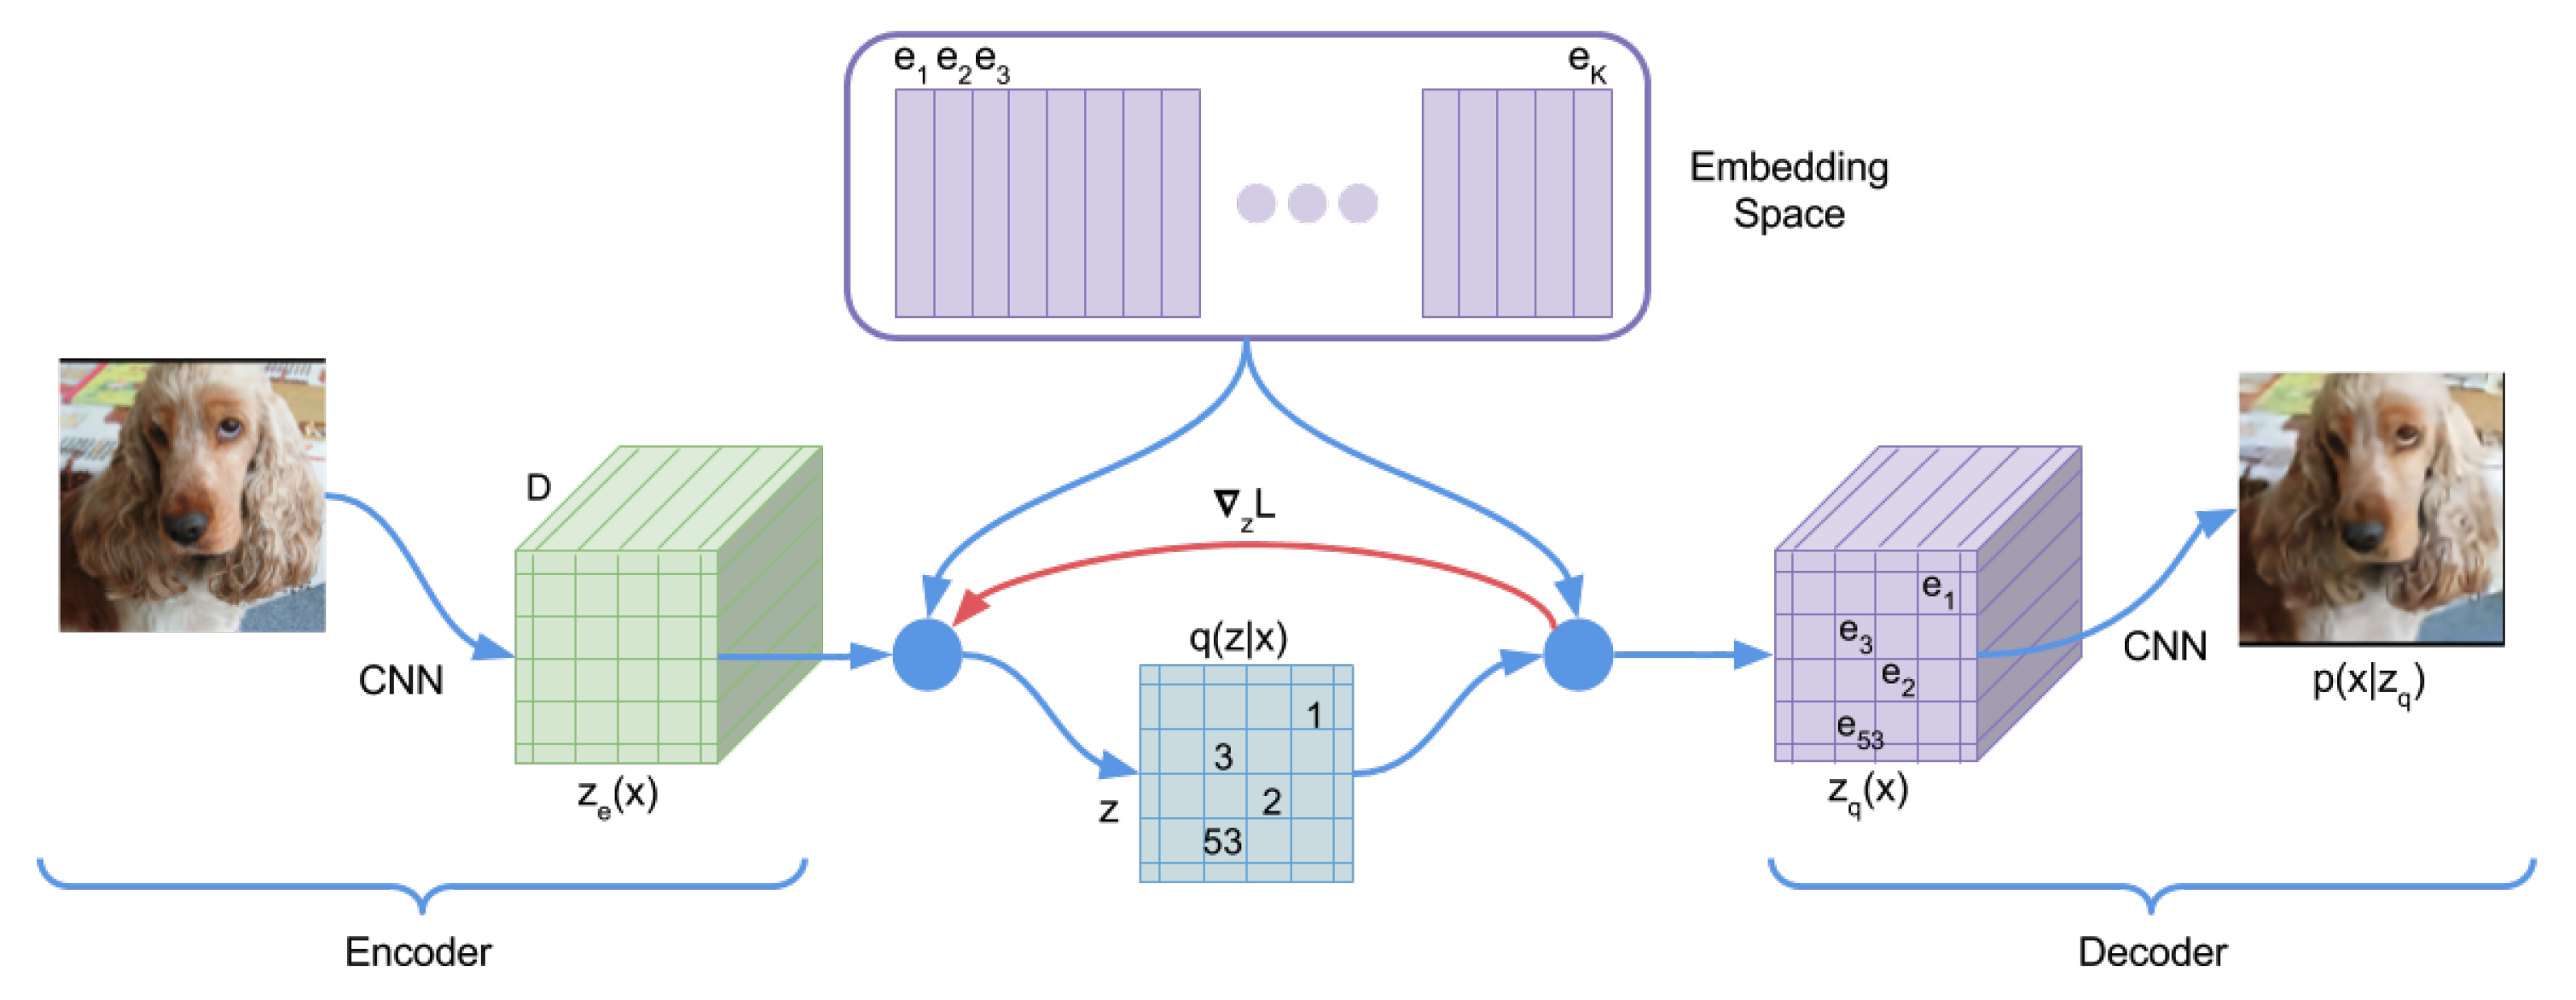" width=80%>

**順伝播**

エンコーダの出力を$z_e$としたとき，デコーダの入力$z_q$としてはembedding space（codebookなどとも呼ばれる）の中からL2ノルムで$z_e$に最も近いベクトル$e_k$が選ばれます．

$$
z_q({\bf x}) = e_k, \quad \rm{where} \; k = \rm{argmin}_j || z_e({\bf x}) - e_j ||_2
$$

VAEにおいてガウス分布を仮定していた事後分布 $q(z|{\bf x})$はカテゴリ分布となり，$z$の実現値は以下のようにone-hotベクトルで表されます．

$$
q_{\phi}(z = k | {\bf x}) =
\begin{cases}
  1 \quad \rm{for} \; k = \rm{argmin}_j ||z_e ({\bf x}) - e_j||_2 \\
  0 \quad \rm{otherwise}
\end{cases}
$$

デコーダの入力$z_q$をサンプリングする（上記argminを満たす$e_k$を選ぶ）ためには，これとcodebook vectors ${\bf e}$の行列積を計算すれば良いことがわかります．

<br>

**逆伝播**

順伝播で最も距離が近いベクトルを選ぶ操作（argmin）には勾配が伝わりません．VQ-VAEでは，単純に$z_q$の勾配を$z_e$にコピーします（図赤線）．このような勾配の推定量をstraight-through estimatorと呼んだりします．

<br>

**目的関数**

$$
\mathcal{L} = \log p({\bf x} | z_q({\bf x})) + || \rm{sg}[z_e({\bf x})] - e ||_2^2 + \beta || z_e({\bf x}) - \rm{sg}[e] ||_2^2
$$

- VAEと同じく，第1項に再構成誤差があります．

- Straight-through estimatorを用いると，再構成誤差による勾配はembedding space ${\bf e}$を通らなくなります．そのため，第2項によってこれを学習します．

  - $\rm{sg}$はstop gradientのことで，この項によりエンコーダは学習されないことを意味します．

- 第2項による${\bf e}$の学習が第1項によるエンコーダの学習に追いつかないと，${\bf e}$の学習は発散してしまう可能性があります．それを避けるため，エンコーダの出力が${\bf e}$から離れすぎないようにする正則化項が3つ目にあります．

### 7.3. VQ-VAEの実装

まずは潜在空間を離散化する部分の実装を行います．ポイントは以下です．

- `self.embedding.weight`からエンコーダの出力に最も近いベクトルを取ってきている．

- この操作に勾配を通すため，straight-through estimatorを実装している．

# WRITE ME

In [45]:
class VectorQuantizer(nn.Module):
    """ 潜在空間の離散化を行う部分 """
    def __init__(self, num_embeds: int, embed_dim: int, beta: float) -> None:
        """
        クラスのコンストラクタ．

        Parameters
        ----------
        num_embeds : int
            Codebook vectors (embedding space)の数．図中のK.
        embed_dim : int
            Codebook vectorsの長さ（embedding spaceの次元数）．
        beta : float
            エンコーダの正則化項の係数．目的関数のbeta.
        """
        super().__init__()

        self.num_embeds = num_embeds
        self.embed_dim = embed_dim
        self.beta = beta

        self.embedding = nn.Embedding(self.num_embeds, self.embed_dim)
        self.embedding.weight.data.uniform_(-1 / self.num_embeds, 1 / self.num_embeds)

    def forward(self, z_e: torch.Tensor) -> Tuple[torch.Tensor]:
        """
        順伝播．

        Parameters
        ----------
        z_e : torch.Tensor ( b, embed_dim, h', w' )
            VQ-VAEのエンコーダの出力．（を_pre_vq_convに通したもの）

        Returns
        ----------
        loss : torch.Tensor (, )
            目的関数の再構成誤差以外の部分．
        z_q : torch.Tensor ( b, embed_dim, h', w' )
            離散化された潜在変数．
        """
        z_e = z_e.permute(0, 2, 3, 1).contiguous() # ( b, h', w', embed_dim )
        z_e_shape = z_e.shape

        z_e_flat = z_e.view(-1, self.embed_dim) # ( b * h' * w', embed_dim )

        # L2ノルムの計算
        distances = (
            torch.sum(z_e_flat**2, dim=1, keepdim=True)
            + torch.sum(self.embedding.weight**2, dim=1)
            - 2 * torch.matmul(z_e_flat, self.embedding.weight.T)
        )
        # ( b * h' * w', num_embeds )

        # 最も距離の近いembedding vectorのインデックス
        encoding_indices = torch.argmin(distances, dim=1)
        # ( b * h' * w', )

        encodings = F.one_hot(encoding_indices, self.num_embeds)
        # ( b * h' * w', num_embeds )

        # One-hotベクトルとcodebook vectorsの行列積を取ってquantize
        # z_q = encodings @ self.embedding.weight
        z_q = encodings.float() @ self.embedding.weight



        # ( b * h' * w', embed_dim )
        z_q = z_q.view(z_e_shape) # ( b, h', w', embed_dim )

        # .detach()が目的関数のs.g. (stop gradient)に対応
        e_latent_loss = F.mse_loss(z_q.detach(), z_e)
        q_latent_loss = F.mse_loss(z_q, z_e.detach())
        loss = q_latent_loss + self.beta * e_latent_loss

        # Straight-through estimatorの実装．
        # z_qの順伝播での値を変えないまま，.detach()によってz_e（入力）からz_q
        # までに行ったすべての計算を計算グラフから切り離す．すると，z_qの勾配 = z_eの勾配になる．
        z_q = (z_q - z_e).detach() + z_e

        z_q = z_q.permute(0, 3, 1, 2).contiguous() # ( b, embed_dim, h', w' )

        # perplexityは予備の情報．
        # avg_probs = torch.mean(encodings, dim=0)
        avg_probs = torch.mean(encodings.float(), dim=0)


        perplexity = torch.exp(-torch.sum(avg_probs * torch.log(avg_probs + 1e-10)))

        return loss, z_q, perplexity, encodings

次に，その他のアーキテクチャ部分を実装します．VAEは簡単のため線形層のみで実装しましたが，ここではVQ-VAEの元論文に従い，convolutional VAEをresidual blocksありで実装します．

In [42]:
class Residual(nn.Module):
    """ Residual Blockの実装 """
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
        num_residual_hiddens: int,
    ) -> None:
        """
        Parameters
        ----------
        in_channels : int
            入力画像のチャンネル数．
        num_hiddens : int
            Convolutional VAEの隠れユニット数．
        num_residual_hiddens : int
            Residual blockの隠れユニット数．
        """
        super().__init__()

        self._block = nn.Sequential(
            nn.ReLU(True),
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=num_residual_hiddens,
                kernel_size=3,
                stride=1,
                padding=1,
                bias=False
            ),
            nn.ReLU(True),
            nn.Conv2d(
                in_channels=num_residual_hiddens,
                out_channels=num_hiddens,
                kernel_size=1,
                stride=1,
                bias=False
            )
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return x + self._block(x)


class ResidualStack(nn.Module):
    """ Residual Blockを任意の数積み上げる """
    def __init__(
        self,
        in_channels: int,
        num_hiddens: int,
        num_residual_layers: int = 2,
        num_residual_hiddens: int = 32,
    ) -> None:
        """
        Parameters
        ----------
        num_residual_layers : int
            Residual block数．
        in_channels, num_hiddens, num_residual_hiddensは同上．
        """
        super().__init__()

        self.num_residual_layers = num_residual_layers
        self.layers = nn.ModuleList(
            [
                Residual(in_channels, num_hiddens, num_residual_hiddens)
                for _ in range(self.num_residual_layers)
            ]
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        for i in range(self.num_residual_layers):
            x = self.layers[i](x)
        return F.relu(x)

In [43]:
class VQVAE(nn.Module):
    """ VQVAEモデルの実装 """
    def __init__(
        self,
        num_hiddens: int,
        num_embeds: int,
        embed_dim: int,
        in_channels: int = 3,
        num_residual_layers: int = 2,
        num_residual_hiddens: int = 32,
        beta: float = 0.25,
    ) -> None:
        """
        Parameters
        ----------
        num_hiddens : int
            Convolutional VAEの隠れユニット数．
        num_embeds : int
            Codebook vectors (embedding space)の数．図中のK.
        embed_dim : int
            Codebook vectorsの長さ（embedding spaceの次元数）．
        in_channels : int
            入力画像のチャンネル数．
        num_residual_layers : int
            Residual block数．
        num_residual_hiddens : int
            Residual blockの隠れユニット数．
        beta : float
            エンコーダの正則化項の係数．目的関数のbeta.
        """
        super().__init__()

        # Encoder, xを入力にガウス分布のパラメータmu, sigmaを出力
        self.conv_enc1 = nn.Conv2d(
            in_channels, num_hiddens//2, kernel_size=4, stride=2, padding=1
        )
        self.conv_enc2 = nn.Conv2d(
            num_hiddens//2, num_hiddens, kernel_size=4, stride=2, padding=1
        )
        self.conv_enc3 = nn.Conv2d(
            num_hiddens, num_hiddens, kernel_size=3, stride=1, padding=1
        )

        self.residual_enc = ResidualStack(
            in_channels=num_hiddens,
            num_hiddens=num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens
        )

        self._pre_vq_conv = nn.Conv2d(
            num_hiddens, embed_dim, kernel_size=1, stride=1
        )

        self._vq = VectorQuantizer(num_embeds, embed_dim, beta)

        # Decoder, zを入力にベルヌーイ分布のパラメータlambdaを出力
        self.conv_dec = nn.Conv2d(
            embed_dim, num_hiddens, kernel_size=3, stride=1, padding=1
        )

        self.residual_dec = ResidualStack(
            in_channels=num_hiddens,
            num_hiddens=num_hiddens,
            num_residual_layers=num_residual_layers,
            num_residual_hiddens=num_residual_hiddens
        )

        self.convt_dec1 = nn.ConvTranspose2d(
            num_hiddens, num_hiddens//2, kernel_size=4, stride=2, padding=1
        )
        self.convt_dec2 = nn.ConvTranspose2d(
            num_hiddens//2, 3, kernel_size=4, stride=2, padding=1
        )

    def _encoder(self, x: torch.Tensor) -> torch.Tensor:
        """
        VQ-VAEのエンコーダ部分．

        Parameters
        ----------
        x : torch.Tensor ( b, c, h, w )
            入力画像（flattenされていない）．

        Returns
        ----------
        z : torch.Tensor ( b, num_hiddens, h', w' )
            Encoderの出力．次に_pre_vq_convに通すことでz_eに対応
        """
        z = F.relu(self.conv_enc1(x))
        z = F.relu(self.conv_enc2(z))
        z = self.conv_enc3(z)

        z = self.residual_enc(z)

        return z

    def _decoder(self, z: torch.Tensor) -> torch.Tensor:
        """
        VQ-VAEのデコーダ部分．

        Parameters
        ----------
        z : torch.Tensor ( b, embed_dim, h', w' )
            離散化された潜在変数．z_qに対応

        Returns
        ----------
        x : torch.Tensor ( b, c, h, w )
            再構成画像．
        """
        x = self.conv_dec(z)

        x = self.residual_dec(x)

        x = F.relu(self.convt_dec1(x))
        x = self.convt_dec2(x)

        return x


    def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        ...
        z_e = self._encoder(x) # ( b, num_hiddens, h', w' )
        z_e = self._pre_vq_conv(z_e) # ( b, embed_dim, h', w' )

        # Move tensors to CPU for the VQ operation
        z_e_cpu = z_e.cpu()
        with torch.no_grad():
            self._vq.embedding.weight.data = self._vq.embedding.weight.data.cpu()  # Move embedding weights to CPU
        loss, z_q_cpu, perplexity, _ = self._vq(z_e_cpu)
        # Move the quantized tensor back to the original device
        z_q = z_q_cpu.to(x.device)

        x = self._decoder(z_q)
        return loss, x, perplexity


    # def forward(self, x: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    #     """
    #     順伝播．

    #     Parameters
    #     ----------
    #     x : torch.Tensor ( b, c, h, w )
    #         入力画像（flattenされていない）．

    #     Returns
    #     ----------
    #     loss : torch.Tensor (, )
    #         目的関数の再構成誤差以外の部分．
    #     x : torch.Tensor ( b, c, h, w )
    #         再構成画像．
    #     perplexity : torch.Tensor ( b, z_dim )
    #         潜在変数．
    #     """
    #     z_e = self._encoder(x) # ( b, num_hiddens, h', w' )

    #     z_e = self._pre_vq_conv(z_e) # ( b, embed_dim, h', w' )

    #     loss, z_q, perplexity, _ = self._vq(z_e)
    #     # (, ), ( b, embed_dim, h', w' ), (, )

    #     x = self._decoder(z_q)

    #     return loss, x, perplexity

### 7.4. 学習

In [46]:
model = VQVAE(num_hiddens=128, num_embeds=512, embed_dim=64).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(n_epochs):
    losses = []
    vq_losses = []
    recon_losses = []

    model.train()
    for x, _ in train_loader:
        x = x.to(device)

        vq_loss, x_recon, perplexity = model(x)

        # Move vq_loss back to the original device
        vq_loss = vq_loss.to(device)

        # ここで再構成誤差を計算．
        recon_loss = F.mse_loss(x, x_recon) / data_variance

        loss = recon_loss + vq_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.cpu().detach().numpy())
        vq_losses.append(vq_loss.cpu().detach().numpy())
        recon_losses.append(recon_loss.cpu().detach().numpy())

    losses_val = []
    model.eval()
    for x, _ in valid_loader:
        x = x.to(device)

        vq_loss, x_recon, perplexity = model(x)

        # Move vq_loss back to the original device
        vq_loss = vq_loss.to(device)

        recon_loss = F.mse_loss(x, x_recon) / data_variance

        loss = recon_loss + vq_loss

        losses_val.append(loss.cpu().detach().numpy())

    print('EPOCH: %d    Train Lower Bound: %lf (KL_loss: %lf. reconstruction_loss: %lf)    Valid Lower Bound: %lf' %
          (epoch+1, np.average(losses), np.average(vq_losses), np.average(recon_losses), np.average(losses_val)))


EPOCH: 1    Train Lower Bound: 178557384960495723741184.000000 (KL_loss: 178557384960495723741184.000000. reconstruction_loss: 0.985636)    Valid Lower Bound: 1714472099551942415482880.000000
EPOCH: 2    Train Lower Bound: 7514959692731046980222976.000000 (KL_loss: 7514959692731046980222976.000000. reconstruction_loss: 0.981039)    Valid Lower Bound: 10440914791794836557004800.000000
EPOCH: 3    Train Lower Bound: 11083075928959785826779136.000000 (KL_loss: 11083075928959785826779136.000000. reconstruction_loss: 0.980617)    Valid Lower Bound: 11443928830686682861797376.000000
EPOCH: 4    Train Lower Bound: 11623683128312945587519488.000000 (KL_loss: 11623683128312945587519488.000000. reconstruction_loss: 0.981153)    Valid Lower Bound: 11848122357614760488337408.000000
EPOCH: 5    Train Lower Bound: 11903587105358386682658816.000000 (KL_loss: 11903587105358386682658816.000000. reconstruction_loss: 0.980582)    Valid Lower Bound: 12050966214213784538447872.000000
EPOCH: 6    Train Lowe

In [47]:
# # オリジナルコード　以下はmpsではエラー吐く。いろいろfloatに変更したら解決した。

# model = VQVAE(num_hiddens=128, num_embeds=512, embed_dim=64).float().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.001)

# for epoch in range(n_epochs):
#     losses = []
#     vq_losses = []
#     recon_losses = []

#     model.train()
#     for x, _ in train_loader:

#         x = x.float().to(device)

#         vq_loss, x_recon, perplexity = model(x)

#         # ここで再構成誤差を計算．
#         recon_loss = F.mse_loss(x, x_recon) / data_variance

#         loss = recon_loss + vq_loss

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()

#         losses.append(loss.cpu().detach().numpy())
#         vq_losses.append(vq_loss.cpu().detach().numpy())
#         recon_losses.append(recon_loss.cpu().detach().numpy())

#     losses_val = []
#     model.eval()
#     for x, _ in valid_loader:

#         x = x.float().to(device)

#         vq_loss, x_recon, perplexity = model(x)

#         recon_loss = F.mse_loss(x, x_recon) / data_variance

#         loss = recon_loss + vq_loss

#         losses_val.append(loss.cpu().detach().numpy())

#     print('EPOCH: %d    Train Lower Bound: %lf (KL_loss: %lf. reconstruction_loss: %lf)    Valid Lower Bound: %lf' %
#           (epoch+1, np.average(losses), np.average(vq_losses), np.average(recon_losses), np.average(losses_val)))

### 7.5. 再構成画像の可視化

Original

Files already downloaded and verified


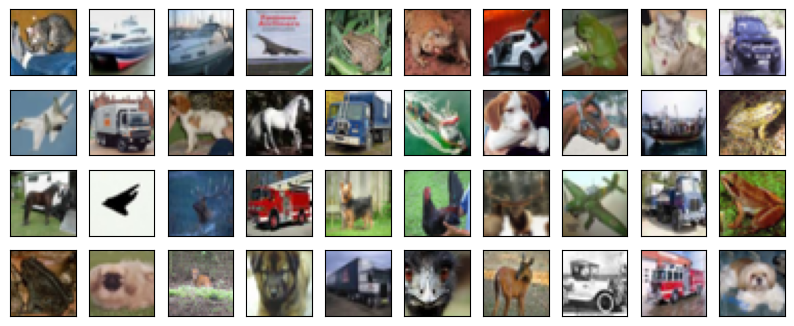

In [48]:
valid_dataset = datasets.CIFAR10(
    './data/CIFAR10', train=False, download=True, transform=transform
)
fig = plt.figure(figsize=(10, 4))
model.eval()
for i in range(40):
    x, _ = valid_dataset[i]

    im = x.view(-1, 32, 32).permute(1, 2, 0).squeeze().numpy() + 0.5

    ax = fig.add_subplot(4, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im)

Reconstruction

Files already downloaded and verified


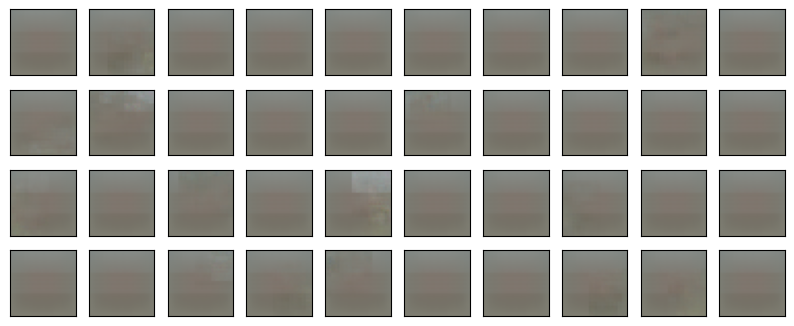

In [50]:
valid_dataset = datasets.CIFAR10(
    './data/CIFAR10', train=False, download=True, transform=transform
)
fig = plt.figure(figsize=(10, 4))
model.eval()
for i in range(40):
    x, _ = valid_dataset[i]

    x = x.unsqueeze(0).to(device)

    _, x_recon, _ = model(x)

    im = x_recon.view(-1, 32, 32).permute(1, 2, 0).detach().cpu().squeeze().numpy() + 0.5

    ax = fig.add_subplot(4, 10, i+1, xticks=[], yticks=[])
    ax.imshow(im)

### 7.6. [補足] VQ-VAEの学習の工夫

離散化操作が本来勾配が通らないものであることに起因し，VQ-VAEの学習は難しくなります．特に，codebook vectorsのうちごく一部しか使われなくなってしまうcodebook collapseが知られます．

ここでは，その学習を改善させる手法についていくつか簡単に紹介します．

- Exponential Moving Average (EMA)
  - Embedding space (codebook vectors) ${\bf e}$は，目的関数第2項からの勾配のみによって更新されます．その代わりに，${\bf e}$をエンコーダの出力のexponential moving averageとして更新することで，学習が安定する場合があります．[[3]](#scrollTo=XMIV_3TOiAq8)で提案されています．

- Random restart
  - Codebook collapseが起こり始めたとき，使われなくなったcodebook vectorをエンコーダ出力のうちランダムな一つにリセットします．[[4]](#scrollTo=XMIV_3TOiAq8)で提案されました．

- Stochastically Quantized VAE (SQ-VAE) [[5]](#scrollTo=XMIV_3TOiAq8)
  - （特に学習初期に）確率的な離散化操作を可能にすることで，codebook collapseを回避しています．

## 8.参考文献

[[1]](https://arxiv.org/abs/1312.6114) Kingma & Welling, 2013,  "Auto-Encoding Variational Bayes", arXiv:1312.6114

[[2]](https://arxiv.org/abs/1401.4082) Rezende et al., 2014, "Stochastic Backpropagation and Approximate Inference in Deep Generative Models", arXiv:1401.4082

[[3]](https://arxiv.org/abs/1711.00937) van den Oord et al., 2017, "Neural Discrete Representation Learning", arXiv:1711.00937

[[4]](https://arxiv.org/abs/2005.00341) Dhariwal et al., 2020, "Jukebox: A Generative Model for Music", arXiv:2005.00341

[[5]](https://arxiv.org/abs/2205.07547) Takida et al., 2022, "SQ-VAE: Variational Bayes on Discrete Representation with Self-annealed Stochastic Quantization", arXiv:2205.07547